In [2]:
'''
Transforms can be applied to PIL images, tensors, ndarrays, or custom data
during creation of the DataSet

complete list of built-in transforms: 
https://pytorch.org/docs/stable/torchvision/transforms.html

On Images
---------
CenterCrop, Grayscale, Pad, RandomAffine
RandomCrop, RandomHorizontalFlip, RandomRotation
Resize, Scale

On Tensors
----------
LinearTransformation, Normalize, RandomErasing

Conversion
----------
ToPILImage: from tensor or ndrarray
ToTensor : from numpy.ndarray or PILImage

Generic
-------
Use Lambda 

Custom
------
Write own class

Compose multiple Transforms
---------------------------
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
'''

import torch
import torchvision
from torch.utils.data import Dataset
import numpy as np


class WineDataset(Dataset):

    def __init__(self, transform=None):
        xy = np.loadtxt('./data/wine/wine.csv', delimiter=',', dtype=np.float32, skiprows=1)
        self.n_samples = xy.shape[0]

        # note that we do not convert to tensor here
        self.x_data = xy[:, 1:]
        self.y_data = xy[:, [0]]

        self.transform = transform

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index] # sample -> tuple

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return self.n_samples

# Custom Transforms
# implement __call__(self, sample)
class ToTensor:
    # Convert ndarrays to Tensors
    def __call__(self, sample):
        inputs, targets = sample # unpack sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

class MulTransform:
    # multiply inputs with a given factor
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, sample):
        inputs, targets = sample
        inputs *= self.factor
        return inputs, targets

print('Without Transform')
dataset = WineDataset()
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))
print(features, labels)

print('\nWith Tensor Transform')
dataset = WineDataset(transform=ToTensor())
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))
print(features, labels)

print('\nWith Tensor and Multiplication Transform')
composed = torchvision.transforms.Compose([ToTensor(), MulTransform(4)])
dataset = WineDataset(transform=composed)
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))
print(features, labels)


Without Transform
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03] [1.]

With Tensor Transform
<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03]) tensor([1.])

With Tensor and Multiplication Transform
<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([5.6920e+01, 6.8400e+00, 9.7200e+00, 6.2400e+01, 5.0800e+02, 1.1200e+01,
        1.2240e+01, 1.1200e+00, 9.1600e+00, 2.2560e+01, 4.1600e+00, 1.5680e+01,
        4.2600e+03]) tensor([1.])


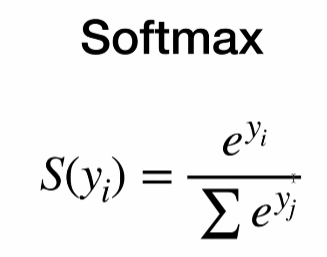

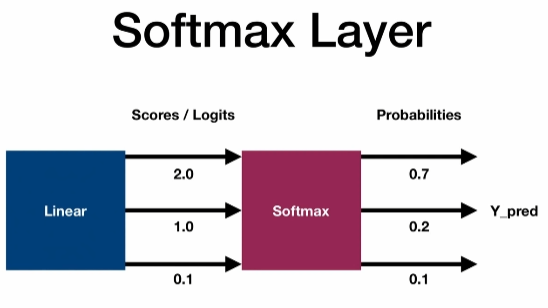

In [46]:
import torch
import torch.nn as nn
import numpy as np

#
#        -> 2.0              -> 0.65  
# Linear -> 1.0  -> Softmax  -> 0.25   -> CrossEntropy(y, y_hat)
#        -> 0.1              -> 0.1                   
#
#     scores(logits)      probabilities
#                           sum = 1.0
#

# Softmax applies the exponential function to each element, and normalizes
# by dividing by the sum of all these exponentials
# -> squashes the output to be between 0 and 1 = probability
# sum of all probabilities is 1
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

x = np.array([2.0, 1.0, 0.1])
outputs = softmax(x)
print('softmax numpy:', outputs)

x = torch.tensor([2.0, 1.0, 0.1])
outputs = torch.softmax(x, dim=0) # along values along first axis
print('softmax torch:', outputs)

softmax numpy: [0.65900114 0.24243297 0.09856589]
softmax torch: tensor([0.6590, 0.2424, 0.0986])


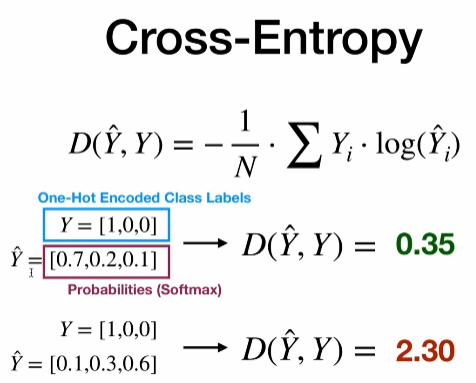

Good prediction -> Low Cross-Entropy Loss  
Bad prediction  -> High Cross-Entropy Loss

In [8]:
# Cross entropy
# Cross-entropy loss, or log loss, measures the performance of a classification model 
# whose output is a probability value between 0 and 1. 
# -> loss increases as the predicted probability diverges from the actual label
def cross_entropy(actual, predicted):
    EPS = 1e-15
    predicted = np.clip(predicted, EPS, 1 - EPS)
    loss = -np.sum(actual * np.log(predicted))
    return loss # / float(predicted.shape[0])

# y must be one hot encoded
# if class 0: [1 0 0]
# if class 1: [0 1 0]
# if class 2: [0 0 1]
Y = np.array([1, 0, 0])
Y_pred_good = np.array([0.7, 0.2, 0.1])
Y_pred_bad = np.array([0.1, 0.3, 0.6])
l1 = cross_entropy(Y, Y_pred_good)
l2 = cross_entropy(Y, Y_pred_bad)
print(f'Loss1 numpy: {l1:.4f}')
print(f'Loss2 numpy: {l2:.4f}')

Loss1 numpy: 0.3567
Loss2 numpy: 2.3026


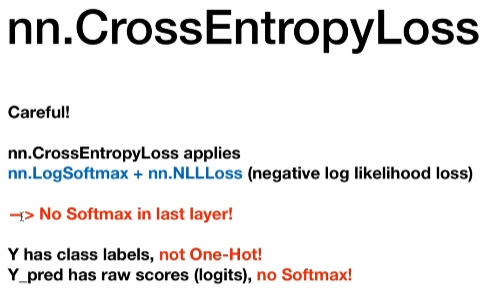

Y에 들어가야하는 값은 레이블 인코딩된 값이 들어가야하고  
X에 들어가야하는 값은 softmax가 적용되기 전인 logits 값이 들어가야한다

In [13]:
# CrossEntropyLoss in PyTorch (applies Softmax)
# nn.LogSoftmax + nn.NLLLoss
# NLLLoss = negative log likelihood loss
loss = nn.CrossEntropyLoss()
# loss(input, target)

# target is of size nSamples = 1
# each element has class label: 0, 1, or 2
# Y (=target) contains class labels, not one-hot
Y = torch.tensor([0])

# input is of size nSamples x nClasses = 1 x 3
# y_pred (=input) must be raw, unnormalizes scores (logits) for each class, not softmax
Y_pred_good = torch.tensor([[2.0, 1.0, 0.1]])
Y_pred_bad = torch.tensor([[0.5, 2.0, 0.3]])
l1 = loss(Y_pred_good, Y)
l2 = loss(Y_pred_bad, Y)

print(f'PyTorch Loss1: {l1.item():.4f}')
print(f'PyTorch Loss2: {l2.item():.4f}')

PyTorch Loss1: 0.4170
PyTorch Loss2: 1.8406


In [18]:
# get predictions
_, predictions1 = torch.max(Y_pred_good, 1)
_, predictions2 = torch.max(Y_pred_bad, 1)
print(f'Actual class: {Y.item()}, Y_pred1: {predictions1.item()}, Y_pred2: {predictions2.item()}')


Actual class: 0, Y_pred1: 0, Y_pred2: 1


CrossEntropyLoss in PyTorch (applies Softmax) -> No Softmax at the end!  
nn.LogSoftmax + nn.NLLLoss  
NLLLoss = negative log likelihood loss  
loss = nn.CrossEntropyLoss()  
loss(input, target) -> logits, LabelEncoding

In [59]:
# allows batch loss for multiple samples
# target is of size nBatch = 3
# each element has class label: 0, 1, or 2

Y = torch.tensor([2, 0, 1])

# input is of size nBatch x nClasses = 3 x 3
# Y_pred are logits (not softmax)
Y_pred_good = torch.tensor(
    [[0.1, 0.2, 3.9], # predict class 2
    [1.2, 0.1, 0.3],  # predict class 0
    [0.3, 2.2, 0.2]]) # predict class 1

Y_pred_bad = torch.tensor(
    [[0.9, 0.2, 0.1],
    [0.1, 0.3, 1.5],
    [1.2, 0.2, 0.5]])

l1 = loss(Y_pred_good, Y)
l2 = loss(Y_pred_bad, Y)
print(f'Batch Loss1:  {l1.item():.4f}')
print(f'Batch Loss2: {l2.item():.4f}')

sm = nn.Softmax(dim=1)
output = sm(Y_pred_good)
print(output)
sm = nn.Softmax(dim=1)
output = sm(Y_pred_bad)
print(output)

Batch Loss1:  0.2834
Batch Loss2: 1.6418
tensor([[0.0214, 0.0236, 0.9550],
        [0.5749, 0.1914, 0.2337],
        [0.1164, 0.7783, 0.1053]])
tensor([[0.5139, 0.2552, 0.2309],
        [0.1593, 0.1946, 0.6461],
        [0.5363, 0.1973, 0.2663]])


아래는 pytorch(loss = nn.CrossEntropyLoss())를 이용하지 않고 numpy로 구현  
loss(input, target) -> softmax, OneHotEncoding

In [50]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1,1)

def cross_entropy(predicted, actual):
    EPS = 1e-15
    predicted = np.clip(predicted, EPS, 1 - EPS)
    loss = -np.sum(actual * np.log(predicted))
    return loss / len(actual) # / float(predicted.shape[0])

Y_pred_good = np.array(
    [[0.1, 0.2, 3.9], # predict class 2
    [1.2, 0.1, 0.3],  # predict class 0
    [0.3, 2.2, 0.2]]) # predict class 1

Y_pred_bad = np.array(
    [[0.9, 0.2, 0.1], # predict class 0
    [0.1, 0.3, 1.5],  # predict class 2
    [1.2, 0.2, 0.5]]) # predict class 0

Y = np.array([[0, 0, 1], # actual class 2 
             [1, 0, 0],  # actual class 0
             [0, 1, 0]]) # actual class 1

print("After Softmax (Y_pred_good): \n",softmax(Y_pred_good))
print("After Softmax (Y_pred_bad): \n",softmax(Y_pred_bad))
print("Batch Loss1: ",cross_entropy(softmax(Y_pred_good), Y)) 
print("Batch Loss2: ",cross_entropy(softmax(Y_pred_bad), Y))

After Softmax (Y_pred_good): 
 [[0.02136462 0.02361156 0.95502382]
 [0.57489742 0.19136673 0.23373585]
 [0.11640452 0.77826832 0.10532716]]
After Softmax (Y_pred_bad): 
 [[0.51389725 0.25519382 0.23090892]
 [0.15932186 0.19459616 0.64608199]
 [0.53634696 0.19731102 0.26634202]]
Batch Loss1:  0.28342219143671027
Batch Loss2:  1.64184493529332


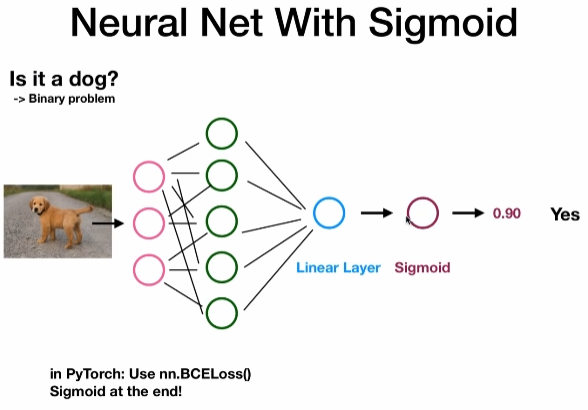

In [54]:
# Binary classification
class NeuralNet1(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet1, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) # (28*28, 5)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)  # (5, 1)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        # sigmoid at the end
        y_pred = torch.sigmoid(out)
        return y_pred

model = NeuralNet1(input_size=28*28, hidden_size=5)
criterion = nn.BCELoss()

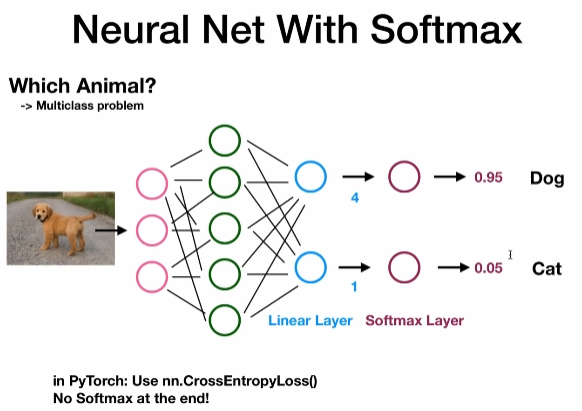

In [53]:
# Multiclass problem
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet2, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) # (28*28, 5)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes) # (5, 3)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        # no softmax at the end
        return out

model = NeuralNet2(input_size=28*28, hidden_size=5, num_classes=3)
criterion = nn.CrossEntropyLoss()  # (applies Softmax)

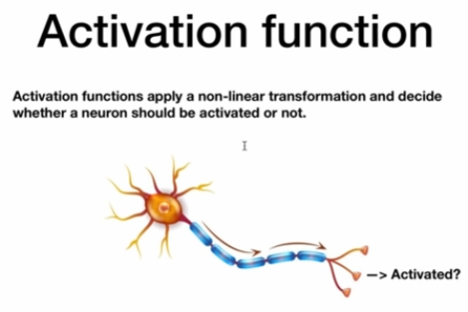

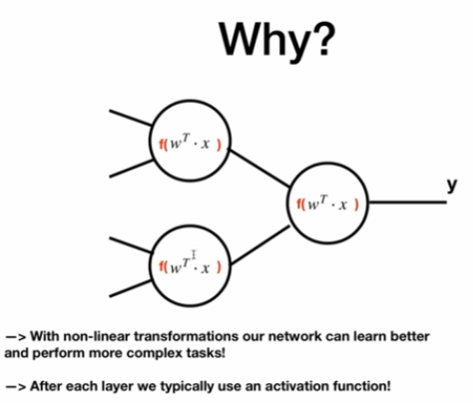

nn.ReLU() creates an nn.Module which you can add e.g. to an nn.Sequential model.  
torch.relu on the other side is just the functional API call to the relu function,  
so that you can add it e.g. in your forward method yourself.

In [62]:
# option 1 (create nn modules)
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU() # nn.Sigmoid, nn.Softmax, nn.TanH, nn.LeakyReLU
        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

# option 2 (use activation functions directly in forward pass)
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = torch.relu(self.linear1(x))
        out = torch.sigmoid(self.linear2(out))
        return out

In [63]:
# output = w*x + b
# output = activation_function(output)
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.tensor([-1.0, 1.0, 2.0, 3.0])

# sofmax
output = torch.softmax(x, dim=0)
print(output)
sm = nn.Softmax(dim=0)
output = sm(x)
print(output)

# sigmoid 
output = torch.sigmoid(x)
print(output)
s = nn.Sigmoid()
output = s(x)
print(output)

#tanh
output = torch.tanh(x)
print(output)
t = nn.Tanh()
output = t(x)
print(output)

# relu
output = torch.relu(x)
print(output)
relu = nn.ReLU()
output = relu(x)
print(output)

# leaky relu
output = F.leaky_relu(x)
print(output)
lrelu = nn.LeakyReLU()
output = lrelu(x)
print(output)

tensor([0.0120, 0.0889, 0.2418, 0.6572])
tensor([0.0120, 0.0889, 0.2418, 0.6572])
tensor([0.2689, 0.7311, 0.8808, 0.9526])
tensor([0.2689, 0.7311, 0.8808, 0.9526])
tensor([-0.7616,  0.7616,  0.9640,  0.9951])
tensor([-0.7616,  0.7616,  0.9640,  0.9951])
tensor([0., 1., 2., 3.])
tensor([0., 1., 2., 3.])
tensor([-0.0100,  1.0000,  2.0000,  3.0000])
tensor([-0.0100,  1.0000,  2.0000,  3.0000])
